In [1]:
# import pyspark to process large files and create a new spark session
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, asc, desc, to_timestamp, first
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession\
    .builder\
    .master('local[*]')\
    .config("spark.driver.memory", "4g")\
    .appName('process_tripdata')\
    .getOrCreate()

In [2]:
# read all months trip_dow_time
jan_trip_dow_time = spark\
    .read\
    .csv('/media/felipe/Files/repos/tcc/nyc_data/csv/2019/01/trip_dow_time.csv', header=True)

feb_trip_dow_time = spark\
    .read\
    .csv('/media/felipe/Files/repos/tcc/nyc_data/csv/2019/02/trip_dow_time.csv', header=True)

mar_trip_dow_time = spark\
    .read\
    .csv('/media/felipe/Files/repos/tcc/nyc_data/csv/2019/03/trip_dow_time.csv', header=True)

apr_trip_dow_time = spark\
    .read\
    .csv('/media/felipe/Files/repos/tcc/nyc_data/csv/2019/04/trip_dow_time.csv', header=True)

may_trip_dow_time = spark\
    .read\
    .csv('/media/felipe/Files/repos/tcc/nyc_data/csv/2019/05/trip_dow_time.csv', header=True)

jun_trip_dow_time = spark\
    .read\
    .csv('/media/felipe/Files/repos/tcc/nyc_data/csv/2019/06/trip_dow_time.csv', header=True)

jul_trip_dow_time = spark\
    .read\
    .csv('/media/felipe/Files/repos/tcc/nyc_data/csv/2019/07/trip_dow_time.csv', header=True)

aug_trip_dow_time = spark\
    .read\
    .csv('/media/felipe/Files/repos/tcc/nyc_data/csv/2019/08/trip_dow_time.csv', header=True)

sep_trip_dow_time = spark\
    .read\
    .csv('/media/felipe/Files/repos/tcc/nyc_data/csv/2019/09/trip_dow_time.csv', header=True)

oct_trip_dow_time = spark\
    .read\
    .csv('/media/felipe/Files/repos/tcc/nyc_data/csv/2019/10/trip_dow_time.csv', header=True)

nov_trip_dow_time = spark\
    .read\
    .csv('/media/felipe/Files/repos/tcc/nyc_data/csv/2019/11/trip_dow_time.csv', header=True)

dec_trip_dow_time = spark\
    .read\
    .csv('/media/felipe/Files/repos/tcc/nyc_data/csv/2019/12/trip_dow_time.csv', header=True)

In [3]:
trip_dow_times = jan_trip_dow_time\
    .union(feb_trip_dow_time)\
    .union(mar_trip_dow_time)\
    .union(apr_trip_dow_time)\
    .union(may_trip_dow_time)\
    .union(jun_trip_dow_time)\
    .union(jul_trip_dow_time)\
    .union(aug_trip_dow_time)\
    .union(sep_trip_dow_time)\
    .union(oct_trip_dow_time)\
    .union(nov_trip_dow_time)\
    .union(dec_trip_dow_time)

trip_dow_times = trip_dow_times\
    .withColumn('morning', col('morning').cast('int'))\
    .withColumn('day', col('day').cast('int'))\
    .withColumn('noon', col('noon').cast('int'))\
    .withColumn('night', col('night').cast('int'))

trip_dow_times = trip_dow_times\
    .groupBy('day of week')\
    .sum('morning', 'day', 'noon', 'night')

trip_dow_times = trip_dow_times\
    .withColumnRenamed("day of week", "dow")\
    .withColumnRenamed("sum(morning)", "morning")\
    .withColumnRenamed("sum(day)", "day")\
    .withColumnRenamed("sum(noon)", "noon")\
    .withColumnRenamed("sum(night)", "night")

trip_dow_times.show()

+---+-------+-------+--------+--------+
|dow|morning|    day|    noon|   night|
+---+-------+-------+--------+--------+
|fri|4144559|9525900|10533866|14496387|
|thu|3277257|9484917| 9849273|12534655|
|tue|3056159|9172815| 9360345|11127788|
|sat|7179158|7547399|12015681|15170632|
|wed|2979883|9141856| 9499647|11539368|
|mon|3192441|8838168| 9233146| 9916741|
|sun|8296191|6770696|11326296|10581675|
+---+-------+-------+--------+--------+



In [4]:
# change day of week string to number
dow_map_names = [['mon',0],['tue',1],['wed',2],['thu',3],['fri',4],['sat',5],['sun',6]]
dow_map_names_schema = ['map_dow', 'code']

dow_map_df = spark.createDataFrame(data=dow_map_names, schema=dow_map_names_schema)

# dow_map_df.show()

trip_dow_times = trip_dow_times.join(dow_map_df, trip_dow_times.dow == dow_map_df.map_dow)
trip_dow_times = trip_dow_times.drop("map_dow")
trip_dow_times = trip_dow_times.withColumn('morning', trip_dow_times.morning.cast('int'))
trip_dow_times = trip_dow_times.withColumn('day', trip_dow_times.day.cast('int'))
trip_dow_times = trip_dow_times.withColumn('noon', trip_dow_times.noon.cast('int'))
trip_dow_times = trip_dow_times.withColumn('night', trip_dow_times.night.cast('int'))

trip_dow_times.show()

+---+-------+-------+--------+--------+----+
|dow|morning|    day|    noon|   night|code|
+---+-------+-------+--------+--------+----+
|mon|3192441|8838168| 9233146| 9916741|   0|
|tue|3056159|9172815| 9360345|11127788|   1|
|wed|2979883|9141856| 9499647|11539368|   2|
|thu|3277257|9484917| 9849273|12534655|   3|
|fri|4144559|9525900|10533866|14496387|   4|
|sat|7179158|7547399|12015681|15170632|   5|
|sun|8296191|6770696|11326296|10581675|   6|
+---+-------+-------+--------+--------+----+



In [5]:
# cast trip_dow_time df to array of array
trip_dow_times_col = trip_dow_times\
    .orderBy("code")\
    .select("dow","morning","day","noon","night")\
    .collect()

trip_dow_times_arr = np.array(trip_dow_times_col)
# print(trip_dow_times_arr)

<AxesSubplot:title={'center':'Trip qty by day of week and time of day, 2019'}, xlabel='Day of week'>

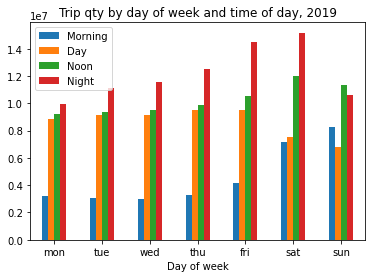

In [16]:
pandas_df = pd.DataFrame(trip_dow_times_arr, columns=['Day of week','Morning','Day','Noon','Night'])

pandas_df['Morning'] = pd.to_numeric(pandas_df['Morning'])
pandas_df['Day'] = pd.to_numeric(pandas_df['Day'])
pandas_df['Noon'] = pd.to_numeric(pandas_df['Noon'])
pandas_df['Night'] = pd.to_numeric(pandas_df['Night'])

pandas_df.plot(x='Day of week'
               ,kind='bar'
               ,title='Trip qty by day of week and time of day, 2019'
               ,rot=0)\
#     .get_figure()\
#     .savefig('/media/felipe/Files/repos/tcc/nyc_data/imgs/2019-trip_dow_time.jpg')